<a href="https://colab.research.google.com/github/harshita23sharma/computer_vision/blob/main/custom_resnet_overfitted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cd /content/drive/

In [3]:
import sys
sys.path.append('/content/drive/')

In [4]:
!pwd

/content


In [5]:
%rm -rf 'CIFAR_10'
!git clone https://github.com/amanjain487/CIFAR_10

Cloning into 'CIFAR_10'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (267/267), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 267 (delta 130), reused 5 (delta 1), pack-reused 0
Receiving objects: 100% (267/267), 63.08 KiB | 2.63 MiB/s, done.
Resolving deltas: 100% (130/130), done.


In [6]:
import sys
sys.path.append('/CIFAR_10/')
# from CIFAR_10 import utils
# from CIFAR_10 import main
# from CIFAR_10.GradCAM.visualize import VisualizeCam

!pip install torchsummary
from torchsummary import summary

import torch

In [7]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-ntt5t968
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-ntt5t968
  Created wheel for albumentations: filename=albumentations-1.0.2-cp37-none-any.whl size=98523 sha256=172f574bcf6b1e79323713c5d4acd2f8cb486e35807ec51675ef2849f8871309
  Stored in directory: /tmp/pip-ephem-wheel-cache-9x_ilsvt/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
# from CIFAR_10.models.reimport torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.maxpool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)


        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                self.conv2,
                self.bn2,
                nn.ReLU()
                
            )

    def forward(self, x):
        out1 = F.relu(self.bn1(self.maxpool1(self.conv1(x))))
        out = F.relu(self.bn2(self.conv2(out1)))
        out = self.shortcut(out)
        # out += out1
        out = F.relu(out)
        return out

class BasicBlock2(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock2, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, 1)
        self.max_pool = nn.MaxPool2d(2,2)

    def forward(self, x):
        out = F.relu(self.bn1(self.max_pool(self.conv1(x))))
        return out



class ResNetCustom(nn.Module):
    def __init__(self, block, block2, num_blocks, num_classes=10):
        super(ResNetCustom, self).__init__()

        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # self._prep_layer = F.relu(self.bn1(self.conv1(x)))

        self.layer1 = self._make_layer(block, 128, num_blocks[0], stride=1)

        self.layer2 = self._make_layer2(block2, 256, num_blocks[1], stride=1)

        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, stride=3, bias=False)
        self.max_pool = nn.MaxPool2d(4,2)
        self.bn2 = nn.BatchNorm2d(256)

        self.layer3 = self._make_layer(block, 512, num_blocks[2], stride=1)

        self.max_pool2 = nn.MaxPool2d(4)
        self.softmax = torch.nn.Softmax(dim=1)
        self.linear = nn.Linear(512*block.expansion, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def _make_layer2(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        r1 = self.layer1(x)
        out = self.layer2(r1)
        r2 = self.layer3(out)
        out = self.max_pool2(r2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.softmax(out)
        return out


def CustomResNet():
    return ResNetCustom(BasicBlock,BasicBlock2, [1, 1, 1],)


# def test():
#     net = CustomResNet()
#     # print(summary(net, input_size=(3, 32, 32)))
#     y = net(torch.randn(1, 3, 32, 32))
#     print(y.size())



# test()

In [30]:
# import os
import argparse


# Training
def train(epoch, net, criterion, optimizer, device, trainloader, train_losses, train_acc):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)' % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    train_losses.append(train_loss/(batch_idx+1))
    train_acc.append(100.*correct/total)
    return train_losses, train_acc


def test(epoch, net, criterion, device, testloader, best_acc, test_losses, test_acc):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    print('Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)' % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    test_losses.append(test_loss/(batch_idx+1))
    test_acc.append(100.*correct/total)
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
    return best_acc, test_losses, test_acc
    


def dataloaders(trainset, testset):
    trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=2)

    testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)
    
    return trainloader, testloader


def start_training(no_of_epoch, net, criterion, optimizer, device, trainloader, testloader, best_acc, scheduler):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    
    for epoch in range(no_of_epoch):
        train_loss, train_acc = train(epoch+1, net, criterion, optimizer, device, trainloader, train_loss, train_acc)
        best_acc, test_loss, test_acc = test(epoch+1, net, criterion, device, testloader, best_acc, test_loss, test_acc)
        scheduler.step(test_loss[-1])
    print("Best Acc is : ", best_acc)
    return train_loss, train_acc, test_loss, test_acc

        


In [10]:
!pip install torch-lr-finder


In [32]:
def define_model_utilities(model,momentum, loss="cross_entropy", optimizer_func="SGD", start_lr=0.001):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    best_acc = 0  # best test accuracy
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

    net = model
    net = net.to(device)
     
    if loss=="cross_entropy":
        criterion = nn.CrossEntropyLoss()
    
    if optimizer_func=="SGD":
        optimizer = optim.SGD(net.parameters(), lr=start_lr,
                      momentum=0.9, weight_decay=5e-6)
        # optimizer = optim.SGD(net.parameters(), start_lr=0.1, momentum)  # Create optimizer
        # optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-2)


    
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 1, total_steps=None, epochs=None, steps_per_epoch=None)
    # scheduler = StepLR(optimizer, lr_step_size, lr_gamma)
    
    # return device, best_acc, classes, net, criterion, optimizer, scheduler
    return device, best_acc, classes, net, criterion, optimizer


In [33]:
!pip install torch-lr-finder

from torch_lr_finder import LRFinder


In [13]:
# # Get best initial learning rate
# initial_lr = lr_finder.best_lr

# # Print learning rate and loss
# print('Learning Rate:', initial_lr)
# print('Loss:', lr_finder.best_loss)

# # Plot learning rate vs loss
# lr_finder.plot()

# # Reset graph
# lr_finder.reset()

In [14]:
!python -m pip install -U matplotlib

  Using cached https://files.pythonhosted.org/packages/24/33/5568d443ba438d95d4db635dd69958056f087e57e1026bee56f959d53f9d/matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl
  Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

import albumentations as A


class CIFAR_10_Dataset(torch.utils.data.Dataset):
  def __init__(self,  dataset, transformer=None):
        self.dataset = dataset
        self.transforms = transformer
  def __len__(self):
        return len(self.dataset)
  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img, target = self.dataset[idx]
        img = img.cpu().detach().numpy()
        img = np.asarray(img).reshape((32,32,3))
        if self.transforms is not None:
            image = self.transforms(image=img)
        img = torch.from_numpy(img.reshape(3,32,32))
        return img, target


def train_transform(train):
  albumentation_train_list = []
  train_list = []
  for i in train:
    if i == "totensor":
      train_list.append(transforms.ToTensor())
    if i == "normalize_normal":
      train_list.append(transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)))
    if i == "normalize_mean":
      train_list.append(transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)))
    if i == "randomcrop":
      train_list.append(transforms.RandomCrop(32, padding=4))
    if i == "horizontal_flip" or i == "flipLR":
      train_list.append(transforms.RandomHorizontalFlip())
    if i == "random_rotate":
      train_list.append(transforms.RandomRotation((-5.0, 5.0), fill=(0,0,0)))
    if i == "cutout":
      albumentation_train_list.append(A.CoarseDropout(p=0.5, max_holes = 1, max_height=8, max_width=8, min_holes = 1, min_height=8, min_width=8, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value = None))
    if i == "shift_scale_rotate":
       albumentation_train_list.append(A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5))
    if i == "grayscale":
       albumentation_train_list.append(A.ToGray(p=0.5))
  
  return transforms.Compose(train_list), A.Compose(albumentation_train_list)



def load_dataset(tensor_train, numpy_train):
  train_dataset = CIFAR_10_Dataset(torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                  transform=tensor_train), numpy_train)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms.Compose([transforms.ToTensor(),
                                                                                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                                                                   ]))
  return train_dataset, testset


def plot_graph(tr_l, tr_a, te_l, te_a):
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(tr_l)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(tr_a)
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(te_l)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(te_a)
  axs[1, 1].set_title("Test Accuracy")


def denormalize(tensor, mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]):
    single_img = False
    if tensor.ndimension() == 3:
      single_img = True
      tensor = tensor[None,:,:,:]

    if not tensor.ndimension() == 4:
        raise TypeError('tensor should be 4D')

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    ret = tensor.mul(std).add(mean)
    return ret[0] if single_img else ret

  
def identify_images(net, criterion, device, testloader, n):
    net.eval()
    correct_images = []
    incorrect_images = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)           
            predicted = outputs.argmax(dim=1, keepdim=True)
            is_correct = predicted.eq(targets.view_as(predicted))
            
            misclassified_inds = (is_correct==0).nonzero()[:,0]
            for mis_ind in misclassified_inds:
              if len(incorrect_images) == n:
                break
              incorrect_images.append({
                  "target": targets[mis_ind].cpu().numpy(),
                  "pred": predicted[mis_ind][0].cpu().numpy(),
                  "img": inputs[mis_ind]
              })

            correct_inds = (is_correct==1).nonzero()[:,0]
            for ind in correct_inds:
              if len(correct_images) == n:
                break
              correct_images.append({
                  "target": targets[ind].cpu().numpy(),
                  "pred": predicted[ind][0].cpu().numpy(),
                  "img": inputs[ind]
              })
    return correct_images, incorrect_images
  
  
def plot_images(img_data, classes):
    figure = plt.figure(figsize=(10, 10))

    num_of_images = len(img_data)
    for index in range(1, num_of_images + 1):
        img = denormalize(img_data[index-1]["img"])  # unnormalize
        plt.subplot(5, 5, index)
        plt.axis('off')
        img = img.cpu().numpy()
        maxValue = np.amax(img)
        minValue = np.amin(img)
        img = np.clip(img, 0, 1)
        img = img/np.amax(img)
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.title("Predicted: %s\nActual: %s" % (classes[img_data[index-1]["pred"]], classes[img_data[index-1]["target"]]))

    plt.tight_layout()


In [16]:
# !sudo pip3 install torchvision --upgrade

In [17]:
# !conda uninstall torchvision
# !pip install torchvision

In [35]:
tensor_transforms, numpy_transforms = train_transform(["randomcrop", "horizontal_flip", "cutout"
, "totensor"
,"normalize_normal"
])

In [36]:
train_set, test_set = load_dataset(tensor_transforms, numpy_transforms)


Files already downloaded and verified
Files already downloaded and verified


In [37]:
train_loader, test_loader = dataloaders(train_set, test_set)

In [38]:
model = CustomResNet()
device, best_acc, classes, net, criterion, optimizer = define_model_utilities(model,
                                                                              momentum=0.9,
                                                                              loss="cross_entropy", 
                                                                              optimizer_func="SGD", 
                                                                              start_lr=0.01,
                                                                              )

In [22]:
# !python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

  Using cached https://files.pythonhosted.org/packages/4c/9b/35ab3469fd1509f7636a344940569ebfd33239673fd2318e80b4700a257c/matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl
  Found existing installation: matplotlib 3.4.2
    Uninstalling matplotlib-3.4.2:
      Successfully uninstalled matplotlib-3.4.2


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.76E-01


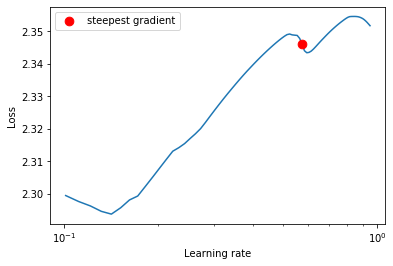

In [23]:
# # # Find learning rate

# from torch_lr_finder import LRFinder

# lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
# lr_finder.range_test(train_loader, val_loader=test_loader,end_lr=1, num_iter=100, step_mode="linear")
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state


In [39]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.2, pct_start=0.208, steps_per_epoch=len(train_loader),
                                                epochs=24,
                                                base_momentum=0.3,
                                                max_momentum = 0.9
                                                )

In [40]:
# train(10, net, criterion, optimizer, device, train_loader, train_losses, train_acc)

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(24):
    train_loss, train_acc = train(epoch+1, net, criterion, optimizer, device, train_loader, train_loss, train_acc)
    best_acc, test_loss, test_acc = test(epoch+1, net, criterion, device, test_loader, best_acc, test_loss, test_acc)
    scheduler.step(test_loss[-1])
print("Best Acc is : ", best_acc)


Epoch: 1
Train Loss: 2.100 | Train Acc: 35.828% (17914/50000)
Test Loss: 2.119 | Test Acc: 33.610% (3361/10000)

Epoch: 2


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 1.955 | Train Acc: 50.926% (25463/50000)
Test Loss: 2.150 | Test Acc: 30.320% (3032/10000)

Epoch: 3
Train Loss: 1.880 | Train Acc: 58.544% (29272/50000)
Test Loss: 2.042 | Test Acc: 42.270% (4227/10000)

Epoch: 4
Train Loss: 1.822 | Train Acc: 64.446% (32223/50000)
Test Loss: 2.024 | Test Acc: 43.770% (4377/10000)

Epoch: 5
Train Loss: 1.785 | Train Acc: 67.982% (33991/50000)
Test Loss: 1.940 | Test Acc: 53.070% (5307/10000)

Epoch: 6
Train Loss: 1.762 | Train Acc: 70.152% (35076/50000)
Test Loss: 1.918 | Test Acc: 55.010% (5501/10000)

Epoch: 7
Train Loss: 1.745 | Train Acc: 71.864% (35932/50000)
Test Loss: 1.889 | Test Acc: 57.720% (5772/10000)

Epoch: 8
Train Loss: 1.714 | Train Acc: 75.178% (37589/50000)
Test Loss: 1.859 | Test Acc: 60.360% (6036/10000)

Epoch: 9
Train Loss: 1.649 | Train Acc: 81.880% (40940/50000)
Test Loss: 1.853 | Test Acc: 62.050% (6205/10000)

Epoch: 10
Train Loss: 1.634 | Train Acc: 83.120% (41560/50000)
Test Loss: 1.845 | Test Acc: 62.060% (6206

In [26]:
# train(10, net, criterion, optimizer, device, train_loader, train_losses, train_acc)

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(24):
    train_loss, train_acc = train(epoch+1, net, criterion, optimizer, device, train_loader, train_loss, train_acc)
    best_acc, test_loss, test_acc = test(epoch+1, net, criterion, device, test_loader, best_acc, test_loss, test_acc)
    scheduler.step(test_loss[-1])
print("Best Acc is : ", best_acc)


Epoch: 1
Train Loss: 1.848 | Train Acc: 61.164% (30582/50000)
Test Loss: 2.196 | Test Acc: 26.200% (2620/10000)

Epoch: 2


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 1.840 | Train Acc: 61.958% (30979/50000)
Test Loss: 2.191 | Test Acc: 26.670% (2667/10000)

Epoch: 3
Train Loss: 1.836 | Train Acc: 62.338% (31169/50000)
Test Loss: 2.189 | Test Acc: 26.850% (2685/10000)

Epoch: 4
Train Loss: 1.833 | Train Acc: 62.632% (31316/50000)
Test Loss: 2.146 | Test Acc: 31.120% (3112/10000)

Epoch: 5
Train Loss: 1.831 | Train Acc: 62.796% (31398/50000)
Test Loss: 2.158 | Test Acc: 29.900% (2990/10000)

Epoch: 6
Train Loss: 1.830 | Train Acc: 62.938% (31469/50000)
Test Loss: 2.168 | Test Acc: 29.070% (2907/10000)

Epoch: 7
Train Loss: 1.826 | Train Acc: 63.360% (31680/50000)
Test Loss: 2.187 | Test Acc: 27.190% (2719/10000)

Epoch: 8
Train Loss: 1.824 | Train Acc: 63.532% (31766/50000)
Test Loss: 2.192 | Test Acc: 26.690% (2669/10000)

Epoch: 9
Train Loss: 1.821 | Train Acc: 63.786% (31893/50000)
Test Loss: 2.180 | Test Acc: 27.660% (2766/10000)

Epoch: 10
Train Loss: 1.821 | Train Acc: 63.848% (31924/50000)
Test Loss: 2.220 | Test Acc: 23.750% (2375

In [ ]:
# # Get best initial learning rate
# initial_lr = lr_finder.best_lr

# # Print learning rate and loss
# print('Learning Rate:', initial_lr)
# print('Loss:', lr_finder.best_loss)

# # Plot learning rate vs loss
# lr_finder.plot()

# # Reset graph
# lr_finder.reset()

In [ ]:
# def find_lr(init_value = 1e-8, final_value=10., beta = 0.98):
#     num = len(train_loader)-1
#     mult = (final_value / init_value) ** (1/num)
#     lr = init_value
#     optimizer.param_groups[0]['lr'] = lr
#     avg_loss = 0.
#     best_loss = 0.
#     batch_num = 0
#     losses = []
#     log_lrs = []
#     for data in train_loader:
#         batch_num += 1
#         #As before, get the loss for this mini-batch of inputs/outputs
#         inputs,labels = data
#         inputs, labels = inputs, labels
#         optimizer.zero_grad()
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         #Compute the smoothed loss
#         avg_loss = beta * avg_loss + (1-beta) *loss.data[0]
#         smoothed_loss = avg_loss / (1 - beta**batch_num)
#         #Stop if the loss is exploding
#         if batch_num > 1 and smoothed_loss > 4 * best_loss:
#             return log_lrs, losses
#         #Record the best loss
#         if smoothed_loss < best_loss or batch_num==1:
#             best_loss = smoothed_loss
#         #Store the values
#         losses.append(smoothed_loss)
#         log_lrs.append(math.log10(lr))
#         #Do the SGD step
#         loss.backward()
#         optimizer.step()
#         #Update the lr for the next step
#         lr *= mult
#         optimizer.param_groups[0]['lr'] = lr
#     return log_lrs, losses

In [ ]:
# find_lr()